In [2]:
import tensorflow as tf

In [3]:
import torch
import torchvision

In [4]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
BASE_PATH = 'space_of_cars/data'
file_directory = os.getcwd()
print(file_directory)
full_list = glob.glob(os.path.join(BASE_PATH, 'Full/*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, 'Free/*.jpg'))

C:\Users\user\Desktop\데이터 청년 캠퍼스 수업\프로젝트 관련\data


In [6]:
full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

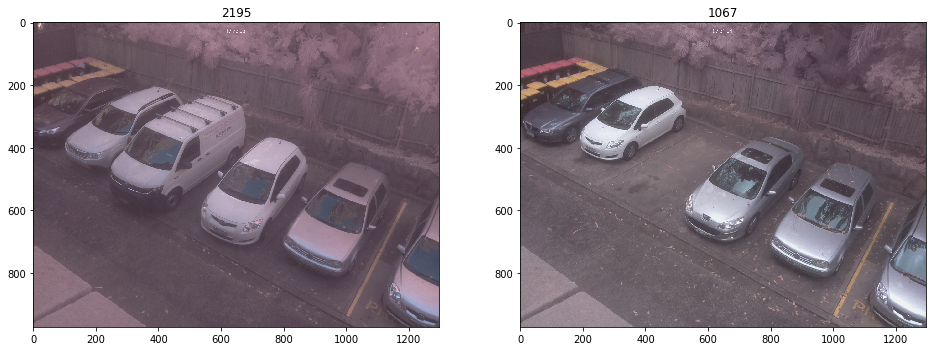

In [7]:
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.title(len(full_list))
plt.imshow(full_img)
plt.subplot(1,2,2)
plt.title(len(free_list))
plt.imshow(free_img)

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range = [0.8, 1.2],
    shear_range=0.01,
    zoom_range = [0.9, 1.1],
    validation_split = 0.1,
    preprocessing_function=preprocess_input
)

In [9]:
val_datagen = ImageDataGenerator(
    validation_split = 0.1,
    preprocessing_function = preprocess_input
)

In [10]:
train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size = (224,224),
    classes = ['Full', 'Free'],
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    subset= 'training'
)

Found 2937 images belonging to 2 classes.


In [11]:
val_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size = (224,224),
    classes = ['Full', 'Free'],
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False,
    subset= 'validation'
)

Found 325 images belonging to 2 classes.


In [12]:
print(val_gen.class_indices)

{'Full': 0, 'Free': 1}


In [13]:
base_model = MobileNetV2(input_shape=(224,224,3),  # MobileNetV2 이미 학습되어있는 모델을 내가 원하는 모델로 개조
                         weights='imagenet',
                         include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x) # 1차원으로 데이터를 펴준다.
output = Dense(2, # 마지막 결과값은 Full:0, Free:1 두개의 이진 결과값이므로 Dense 는 2를 준다.
               activation='softmax')(x)

model = Model(inputs=base_model.input,
              outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 28, 28, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 28, 28, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 28, 28, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 28, 28, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 28, 28, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 14, 14, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 14, 14, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 14, 14, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 14, 14, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 14, 14, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 14, 14, 576)  0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 15, 15, 576)  0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 7, 7, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 7, 7, 576)    2304        block_13_depthwise[0][0]         
__________

__________________________________________________________________________________________________


In [14]:
for layer in model.layers:
    layer.trainable = True

In [15]:
history = model.fit_generator(
    train_gen,
    validation_data = val_gen,
    epochs=5,
    callbacks = [
        ModelCheckpoint('model.h5', monitor='val_acc',
                        save_best_only=True)]
)

Epoch 1/5


W0818 16:24:52.169259 13784 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


91/92 [============================>.] - ETA: 53:20 - loss: 0.8682 - acc: 0.50 - ETA: 26:35 - loss: 0.7428 - acc: 0.68 - ETA: 17:40 - loss: 0.8115 - acc: 0.68 - ETA: 13:13 - loss: 0.7044 - acc: 0.71 - ETA: 10:32 - loss: 0.6885 - acc: 0.71 - ETA: 8:45 - loss: 0.6095 - acc: 0.7396 - ETA: 7:28 - loss: 0.5571 - acc: 0.758 - ETA: 6:31 - loss: 0.5056 - acc: 0.777 - ETA: 5:46 - loss: 0.4790 - acc: 0.795 - ETA: 5:10 - loss: 0.4546 - acc: 0.800 - ETA: 4:41 - loss: 0.4505 - acc: 0.804 - ETA: 4:16 - loss: 0.4173 - acc: 0.820 - ETA: 3:57 - loss: 0.4008 - acc: 0.829 - ETA: 3:46 - loss: 0.4010 - acc: 0.834 - ETA: 3:37 - loss: 0.4217 - acc: 0.835 - ETA: 3:28 - loss: 0.4052 - acc: 0.843 - ETA: 3:21 - loss: 0.3876 - acc: 0.849 - ETA: 3:14 - loss: 0.3749 - acc: 0.854 - ETA: 3:08 - loss: 0.3746 - acc: 0.856 - ETA: 3:22 - loss: 0.3588 - acc: 0.861 - ETA: 3:11 - loss: 0.3432 - acc: 0.867 - ETA: 3:00 - loss: 0.3290 - acc: 0.873 - ETA: 2:51 - loss: 0.3234 - acc: 0.875 - ETA: 2:42 - loss: 0.3159 - acc: 0.879 

91/92 [============================>.] - ETA: 32s - loss: 0.0021 - acc: 1.00 - ETA: 29s - loss: 0.0024 - acc: 1.00 - ETA: 29s - loss: 0.0025 - acc: 1.00 - ETA: 28s - loss: 0.0033 - acc: 1.00 - ETA: 27s - loss: 0.0030 - acc: 1.00 - ETA: 27s - loss: 0.0027 - acc: 1.00 - ETA: 26s - loss: 0.0140 - acc: 0.99 - ETA: 26s - loss: 0.0128 - acc: 0.99 - ETA: 26s - loss: 0.0119 - acc: 0.99 - ETA: 25s - loss: 0.0133 - acc: 0.99 - ETA: 25s - loss: 0.0125 - acc: 0.99 - ETA: 29s - loss: 0.0119 - acc: 0.99 - ETA: 37s - loss: 0.0404 - acc: 0.99 - ETA: 43s - loss: 0.0424 - acc: 0.99 - ETA: 48s - loss: 0.0398 - acc: 0.99 - ETA: 52s - loss: 0.0379 - acc: 0.99 - ETA: 56s - loss: 0.0363 - acc: 0.99 - ETA: 59s - loss: 0.0345 - acc: 0.99 - ETA: 1:01 - loss: 0.0346 - acc: 0.993 - ETA: 1:03 - loss: 0.0331 - acc: 0.993 - ETA: 1:05 - loss: 0.0335 - acc: 0.992 - ETA: 1:07 - loss: 0.0321 - acc: 0.992 - ETA: 1:08 - loss: 0.0329 - acc: 0.991 - ETA: 1:09 - loss: 0.0316 - acc: 0.992 - ETA: 1:09 - loss: 0.0303 - acc: 0.9

91/92 [============================>.] - ETA: 30s - loss: 0.0012 - acc: 1.00 - ETA: 29s - loss: 0.0016 - acc: 1.00 - ETA: 28s - loss: 0.0013 - acc: 1.00 - ETA: 27s - loss: 0.0013 - acc: 1.00 - ETA: 27s - loss: 0.0011 - acc: 1.00 - ETA: 26s - loss: 0.0011 - acc: 1.00 - ETA: 26s - loss: 0.0012 - acc: 1.00 - ETA: 25s - loss: 0.0301 - acc: 0.99 - ETA: 25s - loss: 0.0268 - acc: 0.99 - ETA: 25s - loss: 0.0304 - acc: 0.99 - ETA: 24s - loss: 0.0278 - acc: 0.99 - ETA: 28s - loss: 0.0255 - acc: 0.99 - ETA: 36s - loss: 0.0237 - acc: 0.99 - ETA: 42s - loss: 0.0227 - acc: 0.99 - ETA: 47s - loss: 0.0428 - acc: 0.98 - ETA: 51s - loss: 0.0525 - acc: 0.98 - ETA: 55s - loss: 0.0495 - acc: 0.98 - ETA: 58s - loss: 0.0469 - acc: 0.98 - ETA: 1:00 - loss: 0.0447 - acc: 0.988 - ETA: 1:02 - loss: 0.0433 - acc: 0.989 - ETA: 1:04 - loss: 0.0419 - acc: 0.989 - ETA: 1:06 - loss: 0.0410 - acc: 0.990 - ETA: 1:07 - loss: 0.0393 - acc: 0.990 - ETA: 1:08 - loss: 0.0384 - acc: 0.990 - ETA: 1:08 - loss: 0.0382 - acc: 0.9

### Create New Model

In [17]:
model = load_model(r'model.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2)

new_model = Model(inputs=model.input,
                  outputs=(model.layers[-3].output, 
                           # GlobalAveragePooling2D()(x) 하기전 결과값, Convolution과 Activation까지한 layer
                           # Convolution layer까지가 공간적인 특징을 가진 layer라서 여기까지만된 layer 사용함.
                           model.layers[-1].output)) 
                           # output 2개짜리(모든 layer 통과한 결과값)

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 28, 28, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 28, 28, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 28, 28, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 28, 28, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 28, 28, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 14, 14, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 14, 14, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 14, 14, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 14, 14, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 14, 14, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 14, 14, 576)  0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 15, 15, 576)  0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 7, 7, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 7, 7, 576)    2304        block_13_depthwise[0][0]         
__________

__________________________________________________________________________________________________


In [21]:
parking_list=['Free\img_129173058.jpg',
              'Free\img_815061601.jpg',
              'Free\img_723080007.jpg',
              'Free\img_815061601.jpg',
              'Full\img_127040601.jpg',
              'Full\img_809172559.jpg',
              'Full\img_129063058.jpg',
              'Full\img_822174600.jpg']
test_list =['capture.jpg',
           'capture2.jpg',
           'capture3.jpg']

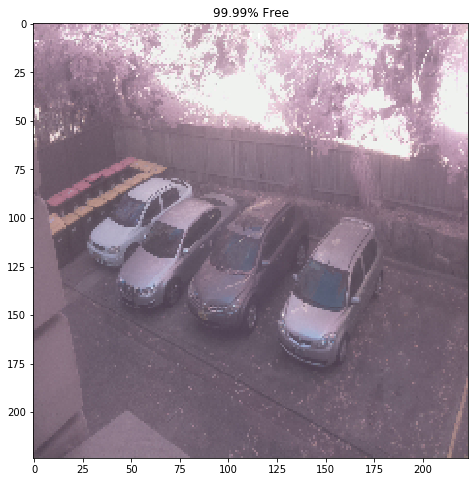

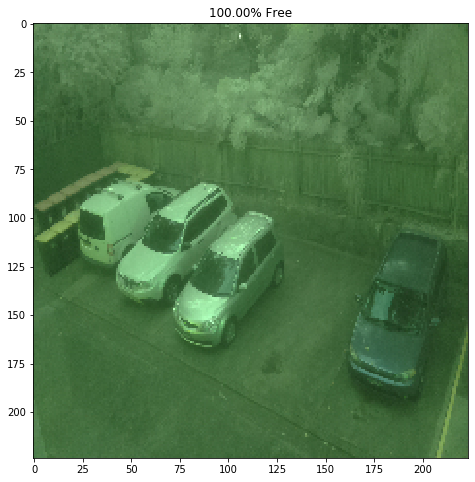

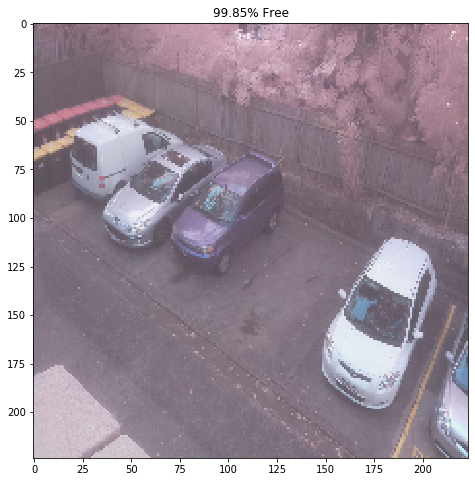

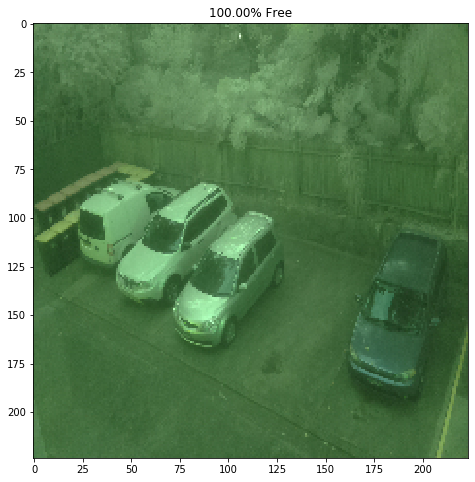

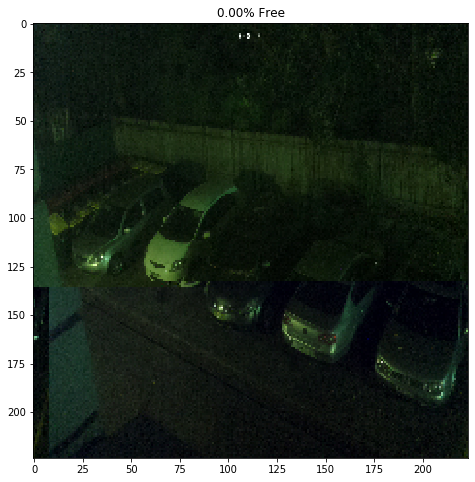

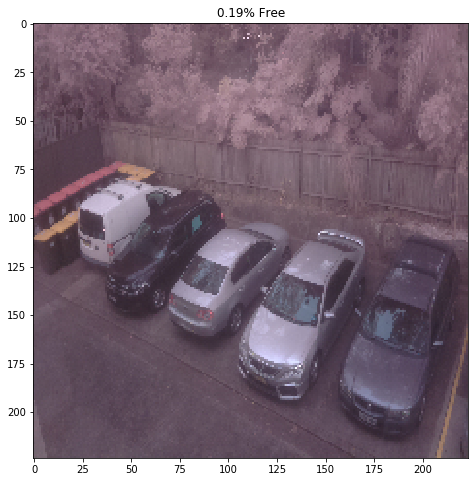

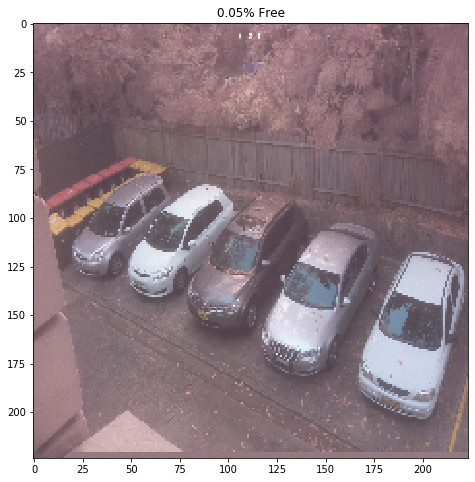

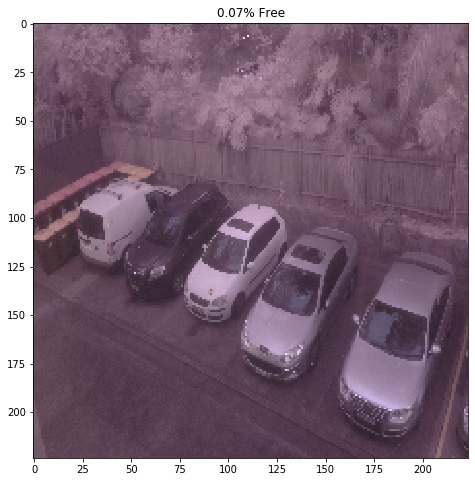

In [18]:
for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(BASE_PATH, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0)) # 사진 전처리
    pred = model.predict(test_input) # 예측
    
    plt.figure(figsize=(8,8))
    plt.title('%.2f%% Free' % (pred[0][1]*100))
    plt.imshow(test_img.astype(np.uint8))

# Draw Activation Map

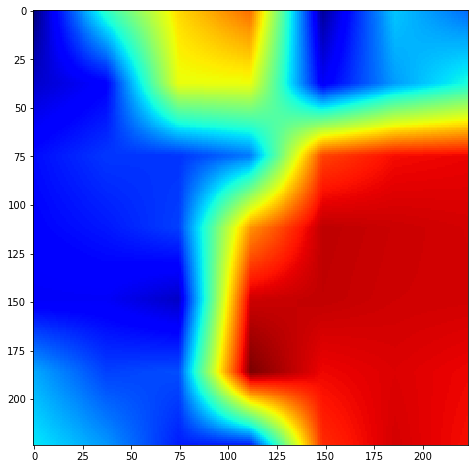

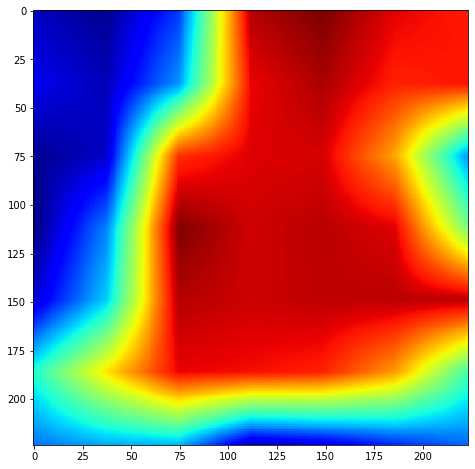

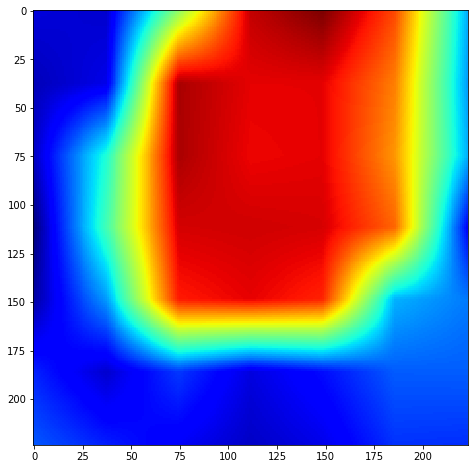

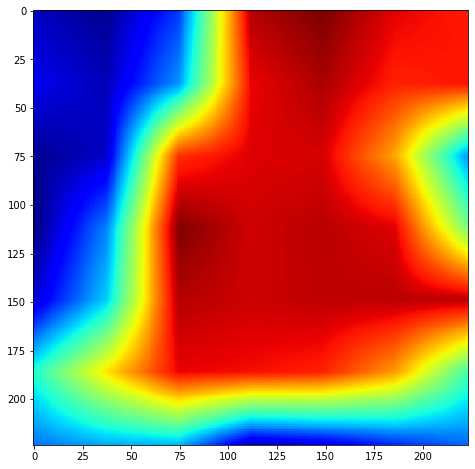

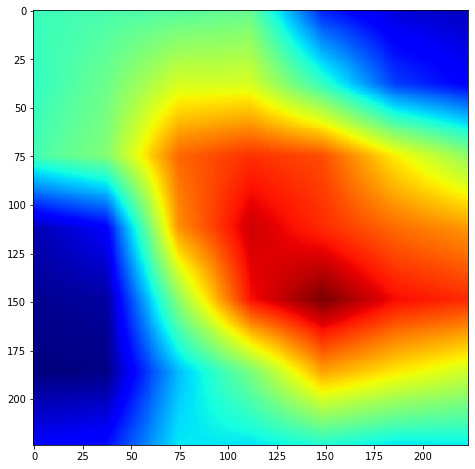

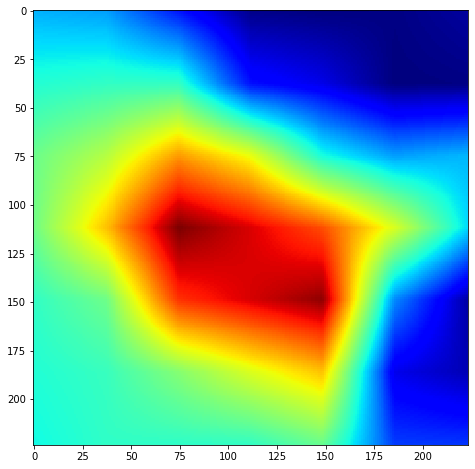

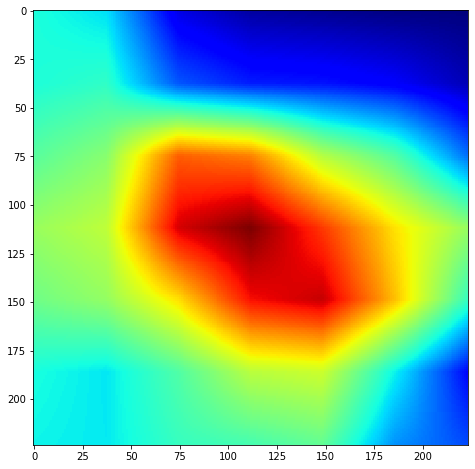

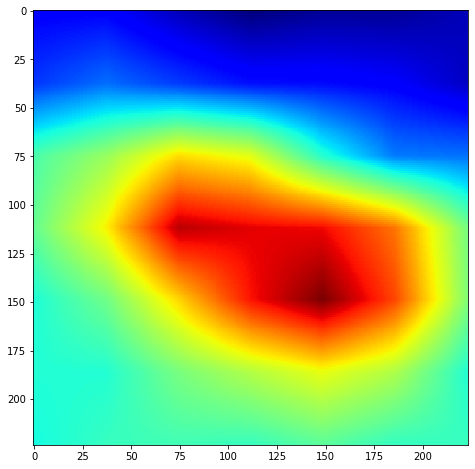

In [19]:
for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(BASE_PATH, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)
    
    # 이 다음 코드부터 Activation Map 코드
    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280), squeeze 함수는 1짜리 axis는 없애줌.
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # 이미지를 확대해줌 32배
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    
    plt.figure(figsize=(8,8))
    plt.imshow(final_output, cmap='jet')

# Result

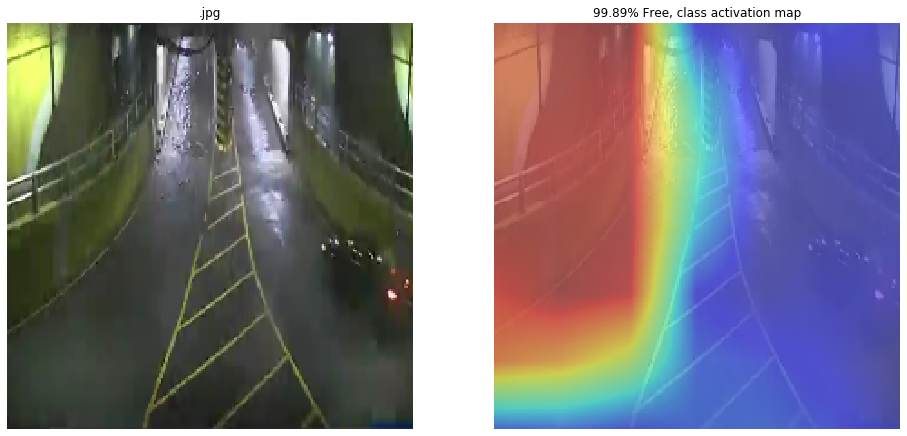

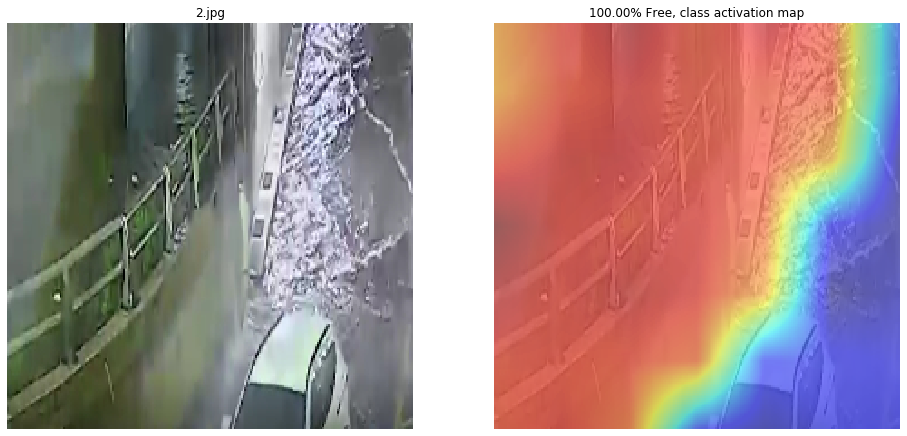

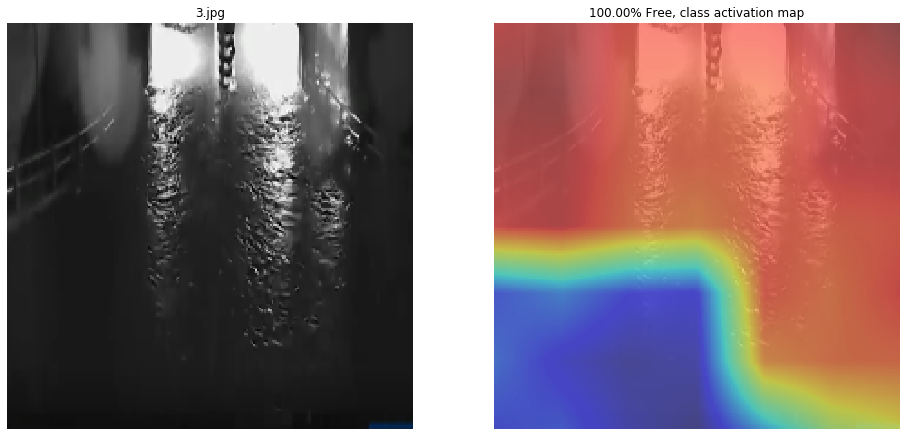

In [25]:
for parking in test_list:
    test_img = img_to_array(load_img(os.path.join('space_of_cars', parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)

    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280)
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 20)

    ax[0].imshow(test_img.astype(np.uint8))
    ax[0].set_title(parking.split('capture')[1])
    ax[0].axis('off')

    ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
    ax[1].imshow(final_output, cmap='jet', alpha=0.5)
    ax[1].set_title('%.2f%% Free, class activation map' % (pred[0][1]*100))
    ax[1].axis('off')
    plt.show()